# Report: AIS Vessel Trajectory Prediction

## Exploratory Data Analysis

### Domain knowledge
AIS is a short range tracking system that transmits ships positions using the high frequency maritime frequency band. It was originally developed as a collision avoidance tool. Each ship transmits a signal containing vessel identity, position, speed and course to surrounding ships and shore stations. The position of the ship is obtained by either using the ships GPS signal or an inertial sensor built into the AIS unit. Static information is sent every sixth minute or at request the ship sends MMSI number, IMO number, name and call sign, length and beam, type of ship and location of position fixing antenna. Dynamic information is sent dependent on the speed and course alterations of the ship. The dynamic information consist of Ships position, accuracy indication, position timestamp and the course over ground. 

It is mandatory for all ships above 300 GT (gross tonnage) to carry AIS, and it is illegal to turn it of. All 300 GT boats mus carry a class A AIS system, while other boats like pleasure crafts can carry a class B AIS system with limited functionality. 

The signals are sensible to noise and enviromental disturbances. Making AIS unpredictable. Some relevant factors are signal propagation conditions, sea state, the height of antennas and strength of the transmitter. These factors giva a large variation in signal transmition length from 20-350 nautical miles. But an average of 40 nautical miles can safely be expected.

### Data intuitive

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import median_filter
import plotly.express as px
import plotly.graph_objects as go

In [3]:
train = pd.read_csv('../Project materials(1)/ais_train.csv', sep='|')
train['time'] = pd.to_datetime(train['time'])

Heading is given in angular degrees from north from 0 deg to 359 deg. It is also quite noisy and could use filtering first. 

In [4]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')

# Example: Applying a moving average filter
window_size = 5  # You can adjust the window size based on the level of smoothing you need

def exponential_moving_average(data, alpha):
    ema = [data[0]]  # Initialize with the first data point
    for i in range(1, len(data)):
        ema.append(alpha * data[i] + (1 - alpha) * ema[i - 1])
    return np.array(ema)

# Example: Applying EMA
alpha = 0.3  # Smoothing factor (0 < alpha <= 1)

def low_pass_filter(data, cutoff_freq, sampling_rate):
    fft_data = np.fft.fft(data)
    frequencies = np.fft.fftfreq(len(data), d=1/sampling_rate)
    
    # Zero out frequencies higher than the cutoff
    fft_data[np.abs(frequencies) > cutoff_freq] = 0
    
    # Inverse FFT to get the filtered signal
    return np.fft.ifft(fft_data)

# Example: Applying a low-pass filter
cutoff_frequency = 0.1  # Define the cutoff frequency
sampling_rate = 1  # Define the sampling rate (based on time intervals of data)

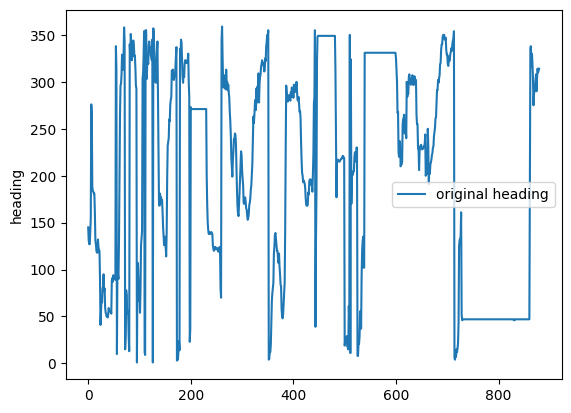

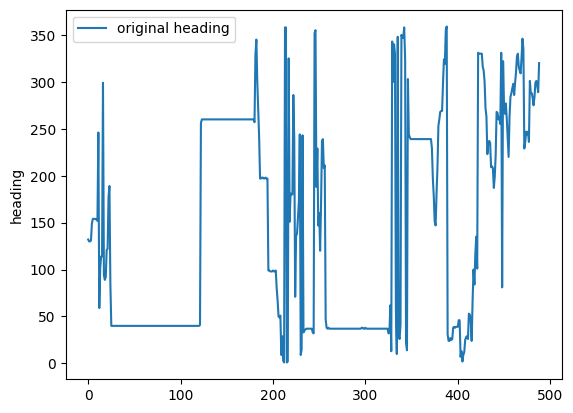

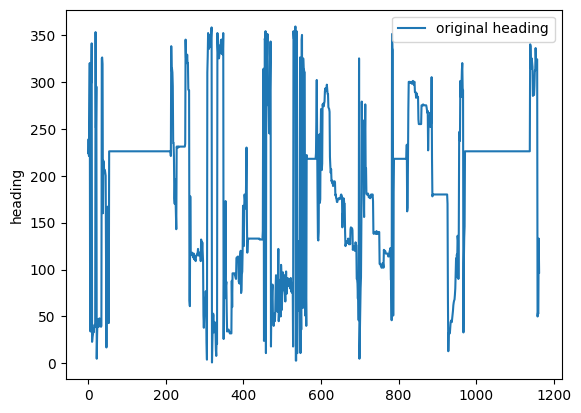

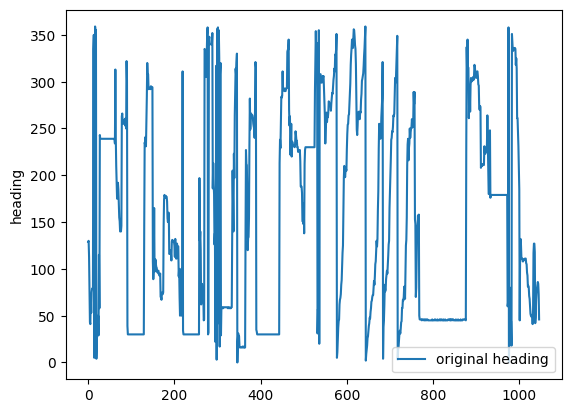

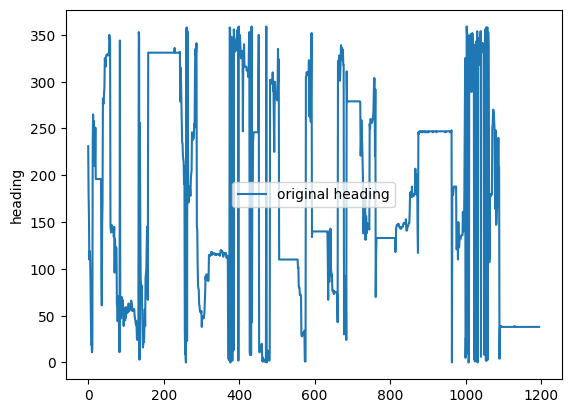

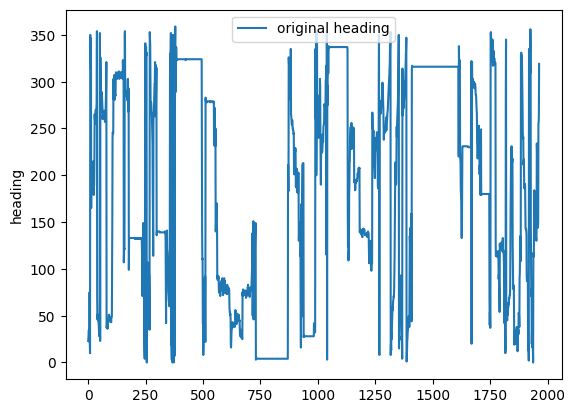

In [5]:
vesselID = train['vesselId'].unique()

for i in range(6):
    dataPoints = train[train['vesselId']== vesselID[i+400]]
    x = range(len(dataPoints))
    sns.lineplot(x=x, y=dataPoints['heading'], label='original heading')
    #sns.lineplot(x=x, y=moving_average(dataPoints['heading'], window_size), label='moving average')
    #sns.lineplot(x=x, y=median_filter(dataPoints['heading'], window_size), label='median filter')
    #sns.lineplot(x=x, y=low_pass_filter(dataPoints['heading'], cutoff_frequency, sampling_rate), label='low pass filter')
    plt.show()

There is a spread in how many samples there is in each timeslot. The AIS should be periodically and it should have the same number within each timeslot. There is also a big difference in the number of samples between the different ships. There is also huge gaps between each sequence of AIS data. Could split up each ship in continous slots where AIS is available. Seems like it spams AIS data when they are stationary. 

The cog measurement is really noisy.



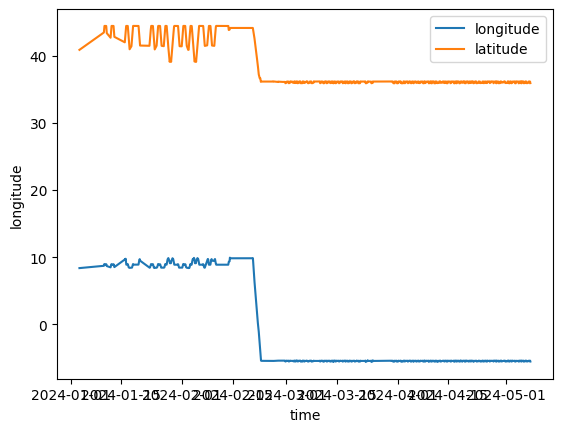

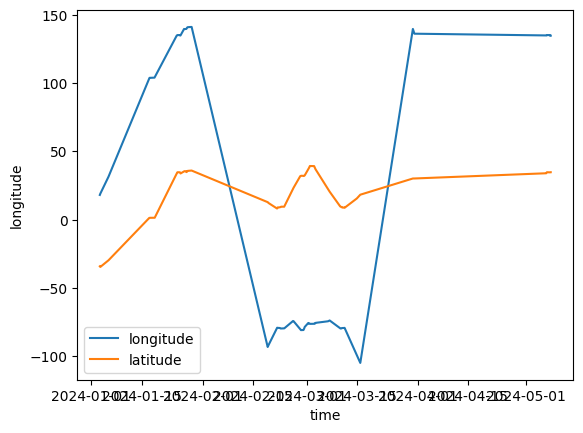

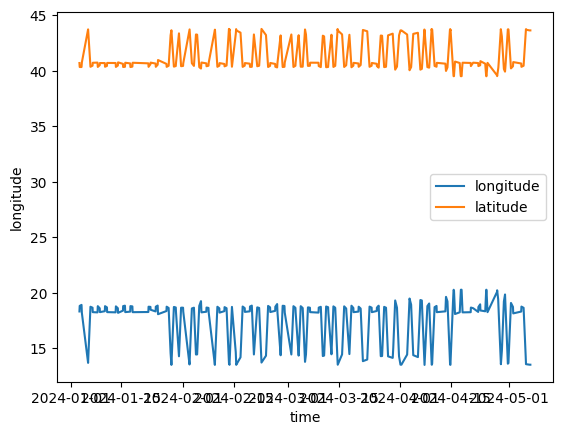

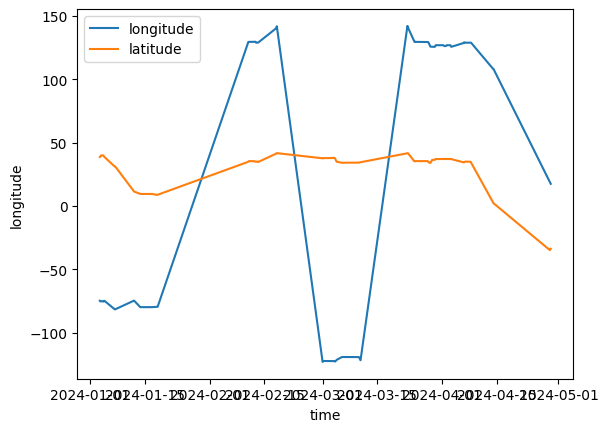

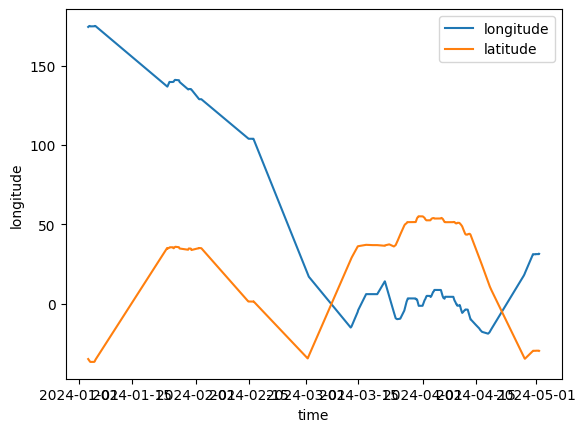

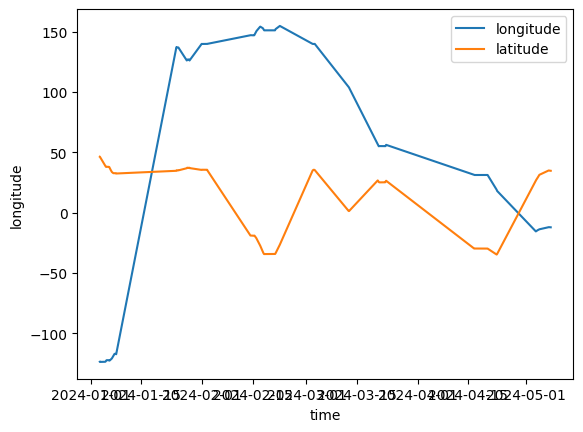

In [6]:
# Add is moored feature
train['isMoored'] = train['navstat']== 5

#remove latitude and longditude measurment if moored
#train.loc[train['isMoored'], ['longitude', 'latitude']] = np.nan
#train = train[~train['isMoored']]

vesselID = train['vesselId'].unique()

for i in range(6):
    dataPoints = train[train['vesselId']== vesselID[i+350]]
    x = range(len(dataPoints))
    sns.lineplot(x=dataPoints['time'], y=dataPoints['longitude'], label='longitude')
    sns.lineplot(x=dataPoints['time'], y=dataPoints['latitude'], label='latitude')
    #sns.lineplot(x=x, y=median_filter(dataPoints['heading'], window_size), label='median filter')
    #sns.lineplot(x=x, y=low_pass_filter(dataPoints['heading'], cutoff_frequency, sampling_rate), label='low pass filter')
    plt.show()

In [7]:
def visualize_vessel_movements(df):
    """
    Visualize vessel movements on a map with lines and markers for each data point.

    Parameters:
    - df (pandas.DataFrame): A DataFrame with columns ['time', 'latitude', 'longitude', 'vesselId'].

    Returns:
    - A Plotly interactive figure.
    """
    # Ensure 'time' is in datetime format for better tooltip handling
    df['time'] = pd.to_datetime(df['time'])
    
    # Sorting the DataFrame by time to ensure lines are drawn correctly
    df = df.sort_values(by=['vesselId', 'time'])

    # Define a color palette
    color_map = px.colors.qualitative.Plotly

    # Mapping each vessel ID to a color
    unique_vessels = df['vesselId'].unique()
    colors = {vessel_id: color_map[i % len(color_map)] for i, vessel_id in enumerate(unique_vessels)}

    # Create the base map with lines
    fig = px.line_geo(df,
                      lat='latitude',
                      lon='longitude',
                      color='vesselId',
                      color_discrete_map=colors,
                      hover_name='vesselId',
                      hover_data={'time': True, 'latitude': ':.3f', 'longitude': ':.3f'},
                      projection='natural earth',
                      title='Vessel Movements Over Time')

    # Add markers for each data point
    for vessel_id in unique_vessels:
        vessel_data = df[df['vesselId'] == vessel_id]
        fig.add_trace(go.Scattergeo(
            lon=vessel_data['longitude'],
            lat=vessel_data['latitude'],
            mode='markers',
            marker=dict(
                size=8,
                color=colors[vessel_id],
                opacity=0.8,
                line=dict(width=1, color='DarkSlateGrey')
            ),
            name=f'Markers for {vessel_id}',
            hoverinfo='text',
            text=vessel_data.apply(lambda row: f'ID: {vessel_id}<br>Time: {row["time"]}<br>Lat: {row["latitude"]:.3f}<br>Lon: {row["longitude"]:.3f}', axis=1)
        ))

    # Enhancing map and layout details
    fig.update_geos(fitbounds="locations", showcountries=True, countrycolor="RebeccaPurple")
    fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0},
                      coloraxis_colorbar=dict(title="Vessel ID"),
                      title_font_size=20)
    
    return fig

In [8]:
for i in range(6):
    dataPoints = train[train['vesselId']== vesselID[i+350]]
    fig = visualize_vessel_movements(dataPoints)
    fig.show()

/var/folders/r6/l18kxywd3tl0swg2fwnp03ww0000gn/T/ipykernel_72890/699849566.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = pd.to_datetime(df['time'])


/var/folders/r6/l18kxywd3tl0swg2fwnp03ww0000gn/T/ipykernel_72890/699849566.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/var/folders/r6/l18kxywd3tl0swg2fwnp03ww0000gn/T/ipykernel_72890/699849566.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/var/folders/r6/l18kxywd3tl0swg2fwnp03ww0000gn/T/ipykernel_72890/699849566.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/var/folders/r6/l18kxywd3tl0swg2fwnp03ww0000gn/T/ipykernel_72890/699849566.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/var/folders/r6/l18kxywd3tl0swg2fwnp03ww0000gn/T/ipykernel_72890/699849566.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Data generation

## Predictors

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from datetime import timedelta

# Load AIS historical data
train = pd.read_csv('/Users/elinelillebokarlsen/ModerneMaskinlæring/AIS-Vessel-Trajectory-Prediction/Project materials(1)/ais_train.csv', sep ='|')  # Replace with your dataset
test = pd.read_csv('/Users/elinelillebokarlsen/ModerneMaskinlæring/AIS-Vessel-Trajectory-Prediction/Project materials(1)/ais_test.csv', sep = ',')

# Preprocessing
train['time'] = pd.to_datetime(train['time'])
train.sort_values(by=['vesselId', 'time'], inplace=True)
train['isMoored'] = train['navstat']== 5
train = train[~train['isMoored']]

test['time'] = pd.to_datetime(test['time'])
test.sort_values(by=['vesselId', 'time'], inplace=True)


# Feature Engineering
train['prev_lat'] = train.groupby('vesselId')['latitude'].shift(1)
train['prev_lon'] = train.groupby('vesselId')['longitude'].shift(1)
train['prev_speed'] = train.groupby('vesselId')['sog'].shift(1)
train['prev_course'] = train.groupby('vesselId')['cog'].shift(1)
train['prev_rotation'] = train.groupby('vesselId')['rot'].shift(1)
train['prev_heading'] = train.groupby('vesselId')['heading'].shift(1)
train['hour'] = train['time'].dt.hour
train['day_of_week'] = train['time'].dt.dayofweek

# Drop rows with missing values
train.dropna(inplace=True)

# Define features and target variables
X_train = train[['prev_lat', 'prev_lon', 'prev_speed', 'prev_course','prev_rotation', 'hour', 'day_of_week', 'prev_heading']]
y_lat_train = train['latitude']
y_lon_train = train['longitude']
X_test = test

# Train the model
model_lat = RandomForestRegressor(n_estimators=100, random_state=42)
model_lat.fit(X_train, y_lat_train)

model_lon = RandomForestRegressor(n_estimators=100, random_state=42)
model_lon.fit(X_train, y_lon_train)

# Make predictions
y_pred_lat = model_lat.predict(X_test)
y_pred_lon = model_lon.predict(X_test)


# Predict future positions
def predict_future_position(vessel_id, timestamp):
    # Fetch the latest known position of the vessel
    latest_data = train[train['vesselId'] == vessel_id].sort_values(by='timestamp').iloc[-1]
    new_data = {
        'prev_lat': latest_data['latitude'],
        'prev_lon': latest_data['longitude'],
        'prev_speed': latest_data['speed'],
        'prev_course': latest_data['course'],
        'hour': timestamp.hour,
        'day_of_week': timestamp.dayofweek
    }
    return model_lat.predict([list(new_data.values())]), model_lon.predict([list(new_data.values())])

# Example of predicting future position for a vessel
future_lat, future_lon = predict_future_position('Vessel123', pd.Timestamp.now() + timedelta(hours=1))
print(f'Predicted Future Position: Latitude {future_lat[0]}, Longitude {future_lon[0]}')


KeyboardInterrupt: 